# Gibbs samplers for Markov Random Fields in JAX

In [1]:
import os

# os.environ['CUDA_VISIBLE_DEVICES'] = ""
os.environ["XLA_FLAGS"] = (
    "--xla_force_host_platform_device_count=4"  # useful when experimenting with sharding
)

In [2]:
import numpy as np
import jax
import matplotlib.pyplot as plt

In [3]:
cpu_device = jax.devices("cpu")[0]
try:
    gpu_device = jax.devices("gpu")[0]
    print(cpu_device, gpu_device)
except RuntimeError:
    print(cpu_device)
print("Number devices", jax.local_device_count())

TFRT_CPU_0 cuda:0
Number devices 1


In [4]:
key = jax.random.PRNGKey(0)

2024-06-14 14:54:43.819219: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Potts model

In [5]:
from mrfx.models import Potts

K = 5
beta = 1
potts_model = Potts(K, beta=beta)

## Standard Gibbs sampler

In [6]:
lx, ly = 256, 256

We will never be able to find the same sample after Gibbs sampler and Gibbs chromatic sampler. But both construct an ergodic Markov chain and the sample is from the same distribution. However, to be on par with the Gibbs chromatic sampler, the Gibbs sampler must have *n_colors* times more iterations than the chromatic

In [7]:
from mrfx.samplers import GibbsSampler

key, subkey = jax.random.split(key, 2)
gibbs = GibbsSampler(lx=lx, ly=ly, eps=0.05, max_iter=1000)
X_init, X_list, n_iter = gibbs.run(potts_model, subkey)

Stopping Gibbs sampler, cause: Convergence criterion is reached


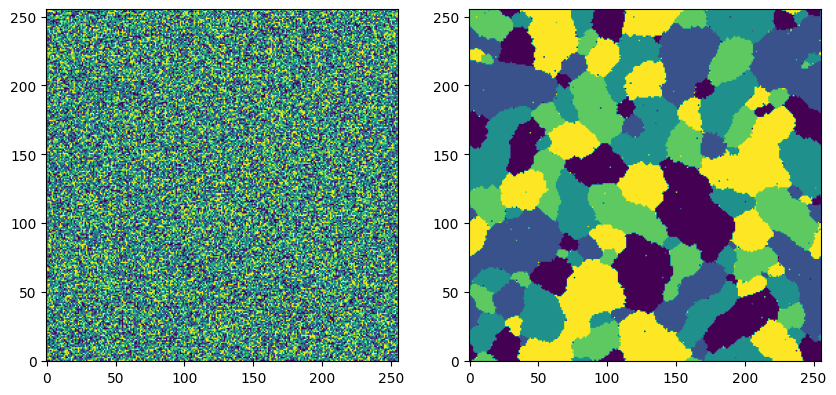

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 15))
axes[0].imshow(X_init, origin="lower")
axes[1].imshow(X_list[-1], origin="lower")
plt.show()

## Chromatic Gibbs sampler

It should be investigated which of the four approaches is the fastest

In [9]:
from mrfx.samplers import ChromaticGibbsSampler

chro_gibbs1 = ChromaticGibbsSampler(
    lx=lx, ly=ly, eps=0.05, max_iter=1000, color_update_type="sequential_in_color"
)
X_init1, X_list1, n_iter1 = chro_gibbs1.run(potts_model, subkey)

chro_gibbs2 = ChromaticGibbsSampler(
    lx=lx, ly=ly, eps=0.05, max_iter=1000, color_update_type="vmap_in_color"
)
X_init2, X_list2, n_iter2 = chro_gibbs2.run(potts_model, subkey)

chro_gibbs3 = ChromaticGibbsSampler(
    lx=lx,
    ly=ly,
    eps=0.05,
    max_iter=1000,
    color_update_type="shard_map_then_vmap_in_color",
    n_devices=jax.local_device_count(),
)
X_init3, X_list3, n_iter3 = chro_gibbs3.run(potts_model, subkey)

chro_gibbs4 = ChromaticGibbsSampler(
    lx=lx,
    ly=ly,
    eps=0.05,
    max_iter=1000,
    color_update_type="shard_map_then_sequential_in_color",
    n_devices=jax.local_device_count(),
)
X_init4, X_list4, n_iter4 = chro_gibbs4.run(potts_model, subkey)

Stopping Gibbs sampler, cause: Convergence criterion is reached
Stopping Gibbs sampler, cause: Convergence criterion is reached
Stopping Gibbs sampler, cause: Convergence criterion is reached
Stopping Gibbs sampler, cause: Convergence criterion is reached


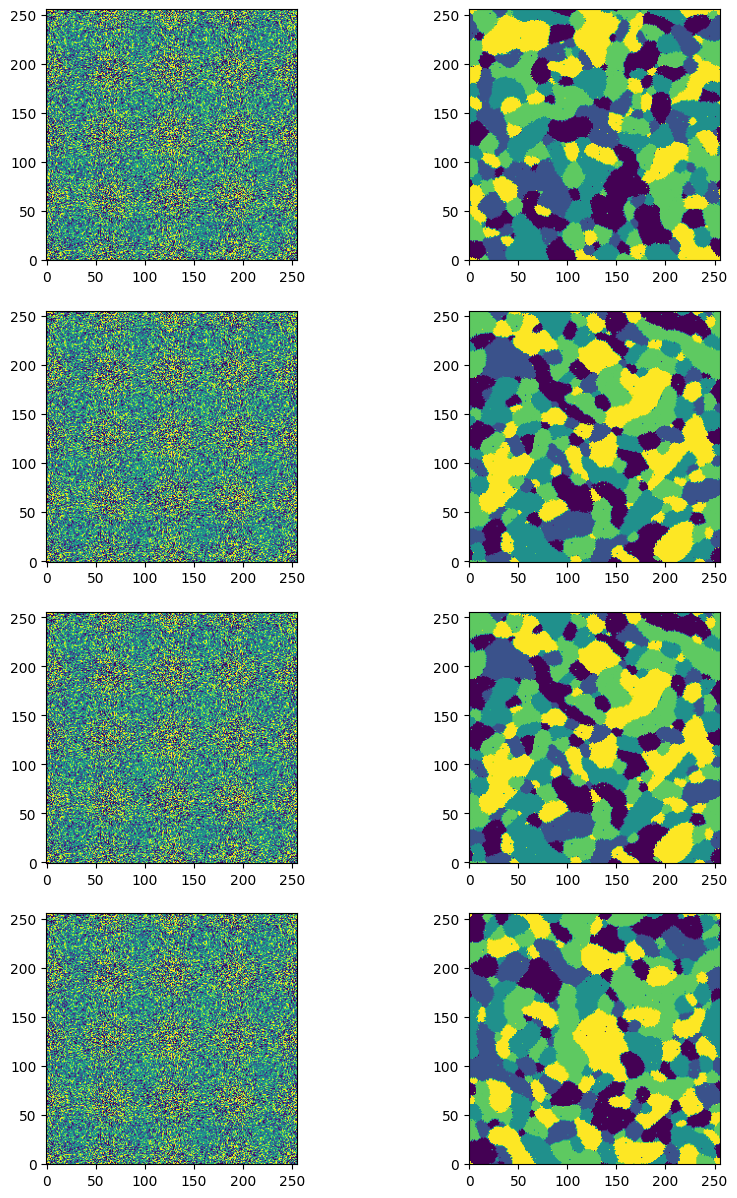

In [10]:
fig, axes = plt.subplots(4, 2, figsize=(10, 15))
axes[0, 0].imshow(X_init1, origin="lower")
axes[0, 1].imshow(X_list1[-1], origin="lower")
axes[1, 0].imshow(X_init2, origin="lower")
axes[1, 1].imshow(X_list2[-1], origin="lower")
axes[2, 0].imshow(X_init3, origin="lower")
axes[2, 1].imshow(X_list3[-1], origin="lower")
axes[3, 0].imshow(X_init4, origin="lower")
axes[3, 1].imshow(X_list4[-1], origin="lower")
plt.show()

## Benchmark

In [11]:
from mrfx.experiments import (
    time_update_one_image,
    time_complete_sampling,
    plot_benchmark,
)

### Chromatic Gibbs sampler: timing one iteration and timing one complete sampling

Rep ( / 30), 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 
k=2, lx=16, ly=16, compilation_time=0.3539247512817383, runtime_mean=0.0002243200937906901
Rep ( / 30), 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 
k=2, lx=32, ly=32, compilation_time=0.36019182205200195, runtime_mean=0.00020751953125
Rep ( / 30), 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 
k=2, lx=64, ly=64, compilation_time=0.3918030261993408, runtime_mean=0.0002723852793375651
Rep ( / 30), 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 
k=2, lx=128, ly=128, compilation_time=0.5507793426513672, runtime_mean=0.0008413473765055339
Rep ( / 30), 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 
k=2, lx=256, ly=256, compilation_time=0.653306245803833, runtime_mean=0.0025649785995483397
Rep ( / 30), 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 2

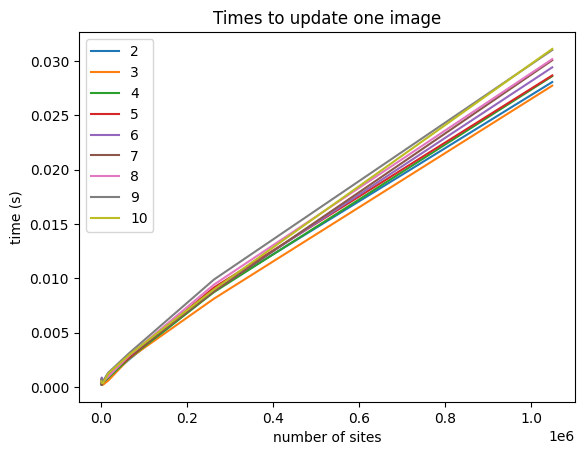

In [12]:
Ks = np.arange(2, 11)
sizes = [(2**e, 2**e) for e in range(4, 11)]
reps = 30

key, subkey = jax.random.split(key, 2)
times = time_update_one_image(
    ChromaticGibbsSampler,
    Potts,
    subkey,
    Ks,
    sizes,
    reps,
    kwargs_sampler={"eps": 0.05, "max_iter": 400, "color_update_type": "vmap_in_color"},
    kwargs_model={"beta": 1.0},
)
plot_benchmark(Ks, sizes, times, title="Times to update one image")

Rep ( / 5): Stopping Gibbs sampler, cause: Convergence criterion is reached
Stopping Gibbs sampler, cause: Convergence criterion is reached
1 Stopping Gibbs sampler, cause: Convergence criterion is reached
2 Stopping Gibbs sampler, cause: Convergence criterion is reached
3 Stopping Gibbs sampler, cause: Convergence criterion is reached
4 Stopping Gibbs sampler, cause: Convergence criterion is reached
5 
k=2, lx=16, ly=16, compilation_time=1.1461374759674072, runtime_mean=0.9651644229888916, n_iter_mean=33.0
Rep ( / 5): Stopping Gibbs sampler, cause: Convergence criterion is reached
Stopping Gibbs sampler, cause: Convergence criterion is reached
1 Stopping Gibbs sampler, cause: Convergence criterion is reached
2 Stopping Gibbs sampler, cause: Convergence criterion is reached
3 Stopping Gibbs sampler, cause: Convergence criterion is reached
4 Stopping Gibbs sampler, cause: Convergence criterion is reached
5 
k=2, lx=32, ly=32, compilation_time=1.1343765258789062, runtime_mean=0.915057277

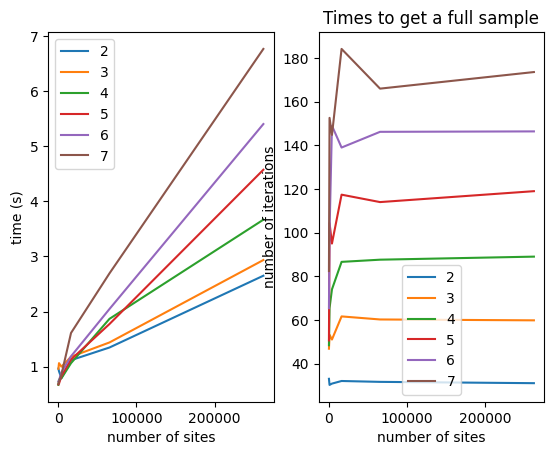

In [13]:
Ks = np.arange(2, 8)
sizes = [(2**e, 2**e) for e in range(4, 10)]
reps = 5

key, subkey = jax.random.split(key, 2)
times, n_iterations = time_complete_sampling(
    ChromaticGibbsSampler,
    Potts,
    subkey,
    Ks,
    sizes,
    reps,
    kwargs_sampler={
        "eps": 0.05,
        "max_iter": 1000,
        "color_update_type": "vmap_in_color",
    },
    kwargs_model={"beta": 1.0},
)
plot_benchmark(Ks, sizes, times, n_iterations, title="Times to get a full sample")